<a href="https://colab.research.google.com/github/saktiworkstation/GNNs-LLMs-Research/blob/main/PENERAPAN_GAT%26GCN_UNTUK_KLASIFIKASI_NODE_PADA_DATASET_CITATION_NETWORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# FINAL PROJECT: PENERAPAN GRAPH NEURAL NETWORK (GNN) UNTUK KLASIFIKASI NODE PADA DATASET CITATION NETWORK DENGAN PENAMBAHAN GAT (GRAPH ATTENTION NETWORK) UNTUK MENINGKATKAN HASIL TRAINING/EVALUASI


**LATAR BELAKANG PERMASALAHAN (Ringkas):**

1. Klasifikasi node pada graph sangat penting untuk banyak aplikasi dunia nyata, seperti
   rekomendasi konten pada social network, klasifikasi topik publikasi pada citation network, dll.
2. GCN (Graph Convolutional Network) efektif, tetapi terkadang kurang mampu menangkap hubungan yang
   lebih kompleks antara node. Penggunaan mekanisme attention dapat membantu.
3. GAT (Graph Attention Network) menggunakan attention mechanism antar node tetangga, sehingga
   setiap node dapat "memperhatikan" tetangga yang lebih relevan dengan bobot yang lebih besar.

**TUJUAN:**

1. Menambah model/algoritme GAT untuk meningkatkan hasil training dan evaluasi.
2. Membandingkan performa GCN (baseline) dengan GAT.

**METODE YANG DIUSULKAN:**

1. Model Baseline: GCN (Graph Convolutional Network)
   - 2 layer GCNConv
   - ReLU activation
   - Optimizer: Adam
   - Loss: NLLLoss
2. Model Improvement: GAT (Graph Attention Network)
   - 2 layer GATConv dengan multi-head attention
   - Dropout untuk mencegah overfitting
   - Parameter heads untuk mengontrol jumlah "attention heads"
   - Optimizer: Adam
   - Loss: NLLLoss
3. Perbandingan hasil akurasi pada validation set dan test set untuk menilai peningkatan performa.

**INFORMASI DATASET:**

- Dataset: "CiteSeer" (~3327 node)
- Link/PyTorch Geometric (Planetoid):
  https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.htmlorch_geometric.datasets.Planetoid
- Fitur: node features, edge_index, label per node

**KODE BERIKUT MEMUAT:**
1. Pemasangan dan import library
2. Memuat dataset CiteSeer
3. EDA sederhana (sama seperti versi sebelumnya)
4. Model GCN baseline
5. Model GAT dengan penambahan dropout dan multi-head attention
6. Training loop & Evaluasi
7. Perbandingan hasil

In [2]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

!pip install torch_geometric

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00


In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
dataset_name = 'CiteSeer'
dataset = Planetoid(root='data/CiteSeer', name=dataset_name)

data = dataset[0]

Processing...
Done!


**EDA SEDERHANA**

In [5]:
print("=== INFORMASI DATASET ===")
print(f"Nama Dataset          : {dataset_name}")
print(f"Jumlah Graph          : {len(dataset)}")
print(f"Jumlah Node           : {data.num_nodes}")
print(f"Jumlah Edge           : {data.num_edges}")
print(f"Jumlah Fitur per Node : {data.num_node_features}")
print(f"Jumlah Kelas          : {dataset.num_classes}")
print("Fitur data            :", data)

=== INFORMASI DATASET ===
Nama Dataset          : CiteSeer
Jumlah Graph          : 1
Jumlah Node           : 3327
Jumlah Edge           : 9104
Jumlah Fitur per Node : 3703
Jumlah Kelas          : 6
Fitur data            : Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


In [6]:
labels = data.y
unique_labels, counts_labels = torch.unique(labels, return_counts=True)
print("\n=== DISTRIBUSI KELAS ===")
for lab, count in zip(unique_labels, counts_labels):
    print(f"Kelas {lab.item()}: {count.item()} node")


=== DISTRIBUSI KELAS ===
Kelas 0: 264 node
Kelas 1: 590 node
Kelas 2: 668 node
Kelas 3: 701 node
Kelas 4: 596 node
Kelas 5: 508 node


In [7]:
print("\n=== EDGE SAMPLE ===")
print(data.edge_index[:, :10])


=== EDGE SAMPLE ===
tensor([[ 628,  158,  486, 1097, 2919, 2933, 3285, 1431, 3219,  467],
        [   0,    1,    1,    1,    1,    1,    2,    3,    3,    4]])


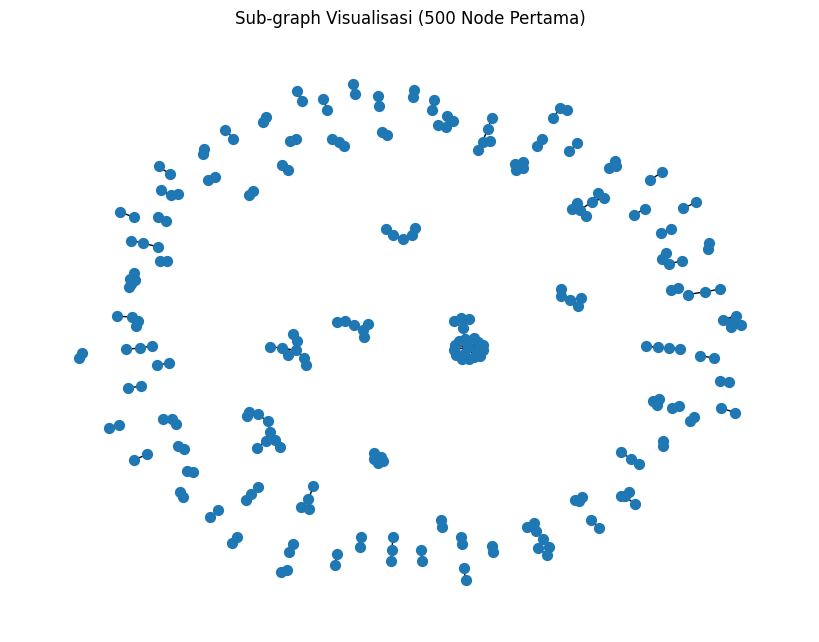

In [12]:
sub_node_count = 677
sub_edge_mask = (data.edge_index[0] < sub_node_count) & (data.edge_index[1] < sub_node_count)
sub_edge_index = data.edge_index[:, sub_edge_mask]

sub_G = nx.Graph()
sub_edges = list(zip(sub_edge_index[0].tolist(), sub_edge_index[1].tolist()))
sub_G.add_edges_from(sub_edges)

plt.figure(figsize=(8, 6))
nx.draw(sub_G, node_size=50)
plt.title("Sub-graph Visualisasi (500 Node Pertama)")
plt.show()

**MODEL BASELINE: GCN (2 Layer GCN)**

In [18]:
class GCNBaseline(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNBaseline, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

**MODEL IMPROVEMENT: GAT (2 Layer GAT)**

In [20]:
class GATNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8, dropout=0.6):
        super(GATNet, self).__init__()
        # GATConv pertama
        self.gat1 = GATConv(in_channels=input_dim,
                            out_channels=hidden_dim,
                            heads=heads,
                            dropout=dropout)
        # GATConv kedua
        # Di layer kedua, biasanya out_channels diset agar total dimension = hidden_dim*heads
        # atau menyesuaikan. Di sini kita ingin output sebanyak "output_dim" untuk klasifikasi.
        # heads=1 di layer kedua agar dimension = output_dim
        self.gat2 = GATConv(in_channels=hidden_dim*heads,
                            out_channels=output_dim,
                            heads=1,
                            dropout=dropout)

        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)  # ELU
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)

**TRAINING LOOP & EVALUASI**

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    preds = out.argmax(dim=1)
    accs = []
    for mask_name in ['train_mask', 'val_mask', 'test_mask']:
        mask = getattr(data, mask_name)
        correct = preds[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs  # [train_acc, val_acc, test_acc]

**Training & Evaluasi GCN**

In [22]:
gcn_model = GCNBaseline(input_dim=dataset.num_node_features,
                        hidden_dim=16,
                        output_dim=dataset.num_classes).to(device)
optimizer_gcn = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)

best_val_acc_gcn = 0
best_test_acc_gcn = 0
epochs = 200

print("\n=== TRAINING GCN BASELINE ===")
for epoch in range(1, epochs+1):
    loss_gcn = train(gcn_model, data, optimizer_gcn)
    train_acc_gcn, val_acc_gcn, test_acc_gcn = test(gcn_model, data)

    if val_acc_gcn > best_val_acc_gcn:
        best_val_acc_gcn = val_acc_gcn
        best_test_acc_gcn = test_acc_gcn

    if epoch % 20 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss_gcn:.4f}, "
              f"Train Acc: {train_acc_gcn:.4f}, Val Acc: {val_acc_gcn:.4f}, Test Acc: {test_acc_gcn:.4f}")

print("\n=== HASIL AKHIR GCN BASELINE ===")
print(f"Best Val Accuracy (GCN)      : {best_val_acc_gcn:.4f}")
print(f"Test Accuracy (GCN, Val terbaik) : {best_test_acc_gcn:.4f}")


=== TRAINING GCN BASELINE ===
Epoch: 020, Loss: 0.0230, Train Acc: 1.0000, Val Acc: 0.6400, Test Acc: 0.6420
Epoch: 040, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.6760, Test Acc: 0.6630
Epoch: 060, Loss: 0.0108, Train Acc: 1.0000, Val Acc: 0.6780, Test Acc: 0.6750
Epoch: 080, Loss: 0.0117, Train Acc: 1.0000, Val Acc: 0.6780, Test Acc: 0.6790
Epoch: 100, Loss: 0.0104, Train Acc: 1.0000, Val Acc: 0.6880, Test Acc: 0.6780
Epoch: 120, Loss: 0.0095, Train Acc: 1.0000, Val Acc: 0.6840, Test Acc: 0.6810
Epoch: 140, Loss: 0.0087, Train Acc: 1.0000, Val Acc: 0.6840, Test Acc: 0.6820
Epoch: 160, Loss: 0.0080, Train Acc: 1.0000, Val Acc: 0.6860, Test Acc: 0.6820
Epoch: 180, Loss: 0.0075, Train Acc: 1.0000, Val Acc: 0.6860, Test Acc: 0.6790
Epoch: 200, Loss: 0.0071, Train Acc: 1.0000, Val Acc: 0.6880, Test Acc: 0.6760

=== HASIL AKHIR GCN BASELINE ===
Best Val Accuracy (GCN)      : 0.6900
Test Accuracy (GCN, Val terbaik) : 0.6800


**Training & Evaluasi GAT**

In [23]:
gat_model = GATNet(input_dim=dataset.num_node_features,
                   hidden_dim=8,
                   output_dim=dataset.num_classes,
                   heads=8,
                   dropout=0.6).to(device)
optimizer_gat = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)

best_val_acc_gat = 0
best_test_acc_gat = 0

print("\n=== TRAINING GAT MODEL ===")
for epoch in range(1, epochs+1):
    loss_gat = train(gat_model, data, optimizer_gat)
    train_acc_gat, val_acc_gat, test_acc_gat = test(gat_model, data)

    if val_acc_gat > best_val_acc_gat:
        best_val_acc_gat = val_acc_gat
        best_test_acc_gat = test_acc_gat

    if epoch % 20 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss_gat:.4f}, "
              f"Train Acc: {train_acc_gat:.4f}, Val Acc: {val_acc_gat:.4f}, Test Acc: {test_acc_gat:.4f}")

print("\n=== HASIL AKHIR GAT MODEL ===")
print(f"Best Val Accuracy (GAT)      : {best_val_acc_gat:.4f}")
print(f"Test Accuracy (GAT, Val terbaik) : {best_test_acc_gat:.4f}")


=== TRAINING GAT MODEL ===
Epoch: 020, Loss: 0.7901, Train Acc: 0.9667, Val Acc: 0.6900, Test Acc: 0.6980
Epoch: 040, Loss: 0.4764, Train Acc: 1.0000, Val Acc: 0.6620, Test Acc: 0.6740
Epoch: 060, Loss: 0.4191, Train Acc: 1.0000, Val Acc: 0.6600, Test Acc: 0.6740
Epoch: 080, Loss: 0.4389, Train Acc: 1.0000, Val Acc: 0.6620, Test Acc: 0.6710
Epoch: 100, Loss: 0.5337, Train Acc: 1.0000, Val Acc: 0.6700, Test Acc: 0.6800
Epoch: 120, Loss: 0.4772, Train Acc: 1.0000, Val Acc: 0.6700, Test Acc: 0.6720
Epoch: 140, Loss: 0.3701, Train Acc: 1.0000, Val Acc: 0.6680, Test Acc: 0.6750
Epoch: 160, Loss: 0.3571, Train Acc: 1.0000, Val Acc: 0.6540, Test Acc: 0.6590
Epoch: 180, Loss: 0.4729, Train Acc: 1.0000, Val Acc: 0.6740, Test Acc: 0.6850
Epoch: 200, Loss: 0.5071, Train Acc: 1.0000, Val Acc: 0.6740, Test Acc: 0.6840

=== HASIL AKHIR GAT MODEL ===
Best Val Accuracy (GAT)      : 0.7040
Test Accuracy (GAT, Val terbaik) : 0.7160


**PERBANDINGAN HASIL GAT&GCN**

In [25]:
print("\n===============================")
print("   PERBANDINGAN MODEL GCN vs GAT")
print("===============================")
print(f"GCN   -> Val: {best_val_acc_gcn:.4f} | Test (Val terbaik): {best_test_acc_gcn:.4f}")
print(f"GAT   -> Val: {best_val_acc_gat:.4f} | Test (Val terbaik): {best_test_acc_gat:.4f}")
print("\nCatatan: Model GAT dapat mengungguli GCN, terutama pada dataset yang kompleks.")
print("         Namun, hasil akhir juga dapat dipengaruhi oleh hyperparameter (hidden dim, heads, lr).")


   PERBANDINGAN MODEL GCN vs GAT
GCN   -> Val: 0.6900 | Test (Val terbaik): 0.6800
GAT   -> Val: 0.7040 | Test (Val terbaik): 0.7160

Catatan: Model GAT dapat mengungguli GCN, terutama pada dataset yang kompleks.
         Namun, hasil akhir juga dapat dipengaruhi oleh hyperparameter (hidden dim, heads, lr).


# RANGKUMAN:


---


1. Model baseline (GCN) telah dilatih dan dievaluasi.
2. Model GAT menggunakan mekanisme attention dengan beberapa heads dan dropout 0.6 untuk mencegah overfitting.
3. Pada kasus data diatas GAT memberikan peningkatan akurasi pada validasi dan test.
4. Pengguna dapat menyesuaikan hyperparameter (hidden_dim, heads, dropout, lr, dll.) untuk hasil yang lebih optimal.